### Аналитика простоев и неэффективности использования вагонного парка
#### Компания управляет вагонным парком и сталкивается с избыточным простоем вагонов на станции дислокации, что снижает операционную эффективность использования подвижного состава.  
#### Цель данного анализа — выявить факторы, ассоциированные с критическим простоем вагонов на станции дислокации, и определить сегменты вагонного парка и инфраструктуры, в которых концентрация таких простоев наиболее высока.
#### При каких условиях и в каких сегментах вагонного парка возникает критический простой вагонов на станции дислокации?
**Объект анализа: вагоны вагонного парка**
**Тип данных:** операционный срез состояния  
**Целевая метрика:** простой на станции дислокации (дни).    
**Критический простой:** более 10 суток.     
**Простой на станции ремонта анализируется отдельно и не является основной метрикой проекта**    
***Простой на станции ремонта анализируется отдельно и не является основной метрикой проекта.
Финансовые потери и оборот не оцениваются в рамках данного анализа из-за отсутствия соответствующих данных.***

#### данные = срез состояния вагонов
#### цель = выявление факторов повышенного простоя

### **Гипотеза 1 — инфраструктурная**
Доля вагонов с критическим простоем различается между дорогами дислокации.
Фактор: Дорога дислокации
Метрика: доля critical_idle = True
Результат: список дорог с наибольшей концентрацией критических простоев

### **Гипотеза 2 — операционная**
Статус вагона связан с вероятностью критического простоя.
Фактор: Состояние вагона (порожний / под грузом / под выгрузкой)
Метрика: доля critical_idle = True
Результат: статусы с повышенным риском простоя   


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np

In [3]:
df = pd.read_excel('/Users/elenatsoi/Desktop/A:B тесты /портфолио /vagons.xlsx')
df.isna().sum()

Номер вагона                           0
Государство, текущей дислокации        0
Дорога дислокации                      0
Станция текущей дислокации             0
Дорога отправления, наименование       0
Станция отправления                    0
Дорога назначения                      0
Станция назначения                     0
Тип вагона                             0
Груж\Порож                             0
Груз                                   4
Дата отправления                       0
Дата следующего планового ремонта      0
Состояние вагона                       0
Простой на станции ремонта (дни)     400
Простой на станции дислокации          0
Остаточный пробег                     11
Депо забраковки ВУ-23                  6
Неисправность текущая                413
dtype: int64

In [4]:
df.dtypes

Номер вагона                                  int64
Государство, текущей дислокации              object
Дорога дислокации                            object
Станция текущей дислокации                   object
Дорога отправления, наименование             object
Станция отправления                          object
Дорога назначения                            object
Станция назначения                           object
Тип вагона                                   object
Груж\Порож                                   object
Груз                                         object
Дата отправления                     datetime64[ns]
Дата следующего планового ремонта    datetime64[ns]
Состояние вагона                             object
Простой на станции ремонта (дни)            float64
Простой на станции дислокации               float64
Остаточный пробег                           float64
Депо забраковки ВУ-23                        object
Неисправность текущая                        object
dtype: objec

In [5]:
df['Номер вагона'].duplicated().sum()


np.int64(0)

In [6]:
df['Номер вагона'].is_unique

True

In [7]:
df.shape

(425, 19)

In [8]:
df. describe()


,Номер вагона,Дата отправления,Дата следующего планового ремонта,Простой на станции ремонта (дни),Простой на станции дислокации,Остаточный пробег
count,4.250000e+02,425,425,25.000000,425.000000,414.000000
mean,3.961551e+07,2025-12-01 09:32:36.705882368,2027-02-17 18:48:16.941176320,25.708400,13.561153,95814.164251
min,2.800220e+07,2025-06-10 00:00:00,2025-12-14 00:00:00,0.990000,0.000000,12246.000000
25%,2.805324e+07,2025-11-26 00:00:00,2026-07-24 00:00:00,4.520000,1.080000,74844.500000
50%,2.880630e+07,2025-12-09 00:00:00,2027-01-22 00:00:00,14.710000,4.830000,96465.000000
75%,6.068291e+07,2025-12-15 00:00:00,2027-09-20 00:00:00,30.980000,17.380000,119216.750000
max,6.781503e+07,2025-12-22 00:00:00,2028-11-12 00:00:00,164.020000,188.790000,158150.000000
std,1.578089e+07,NaN,NaN,36.179889,22.293759,29503.461183


In [9]:
df['Простой на станции ремонта (дни)']=df['Простой на станции ремонта (дни)'].fillna(0)
df['has_defect'] = df['Неисправность текущая'].notna()
df.head(5)

,Номер вагона,"Государство, текущей дислокации",Дорога дислокации,Станция текущей дислокации,"Дорога отправления, наименование",Станция отправления,Дорога назначения,Станция назначения,Тип вагона,Груж\Порож,Груз,Дата отправления,Дата следующего планового ремонта,Состояние вагона,Простой на станции ремонта (дни),Простой на станции дислокации,Остаточный пробег,Депо забраковки ВУ-23,Неисправность текущая,has_defect
0,28005239,РЖД,ЮУР,Карталы I,ЮУР,Нижнеувельская,ЮУР,Тамерлан,КР,ПОР,ВАГОНЫ ЖД СВ,2025-12-18,2026-02-12,Порожний ход,0.0,0.33,76668.0,"ВЧДЭ-6 Инская ОАО ""РЖД""",NaN,False
1,28007268,РЖД,ЮУР,Нижнеувельская,СКВ,Полтавская,ЮУР,Нижнеувельская,КР,ПОР,,2025-12-09,2026-01-22,Под выгрузкой,0.0,6.08,58598.0,"ВЧДр Чеpняховск ОАО ""РЖД""",NaN,False
2,28023646,РЖД,ЮУР,Тамерлан,ЮУР,Пирит,ЮУР,Тамерлан,КР,ПОР,,2025-12-08,2027-01-10,Под погрузкой,0.0,11.63,69393.0,"ВЧДЭ-7 Белогорск ОАО ""РЖД""",NaN,False
3,28039402,РЖД,ЮУР,Пирит,ЮУР,Нижнеувельская,ЮУР,Пирит,КР,ПОР,ВАГОНЫ ЖД СВ,2025-12-17,2027-05-11,Под погрузкой,0.0,2.83,109381.0,ВЧД-8 Астана,NaN,False
4,28052371,РЖД,ЮУР,Кропачево,ПРВ,Покровск-приволжский,ЗСБ,Томск II,КР,ГРУЖ,ПОЛИПРОПИЛЕН,2025-12-16,2026-07-24,Гружёный ход,0.0,1.04,71493.0,ВЧД-19 Костанай,NaN,False


In [10]:
df['critical_idle'] = df['Простой на станции дислокации'] > 5
df['critical_idle'].value_counts(normalize=True)


critical_idle
False    0.505882
True     0.494118
Name: proportion, dtype: float64

In [22]:
# Проверка## Гипотеза 1. Различия по дорогам дислокации
risk_by_road = (
    df.groupby('Дорога дислокации')['critical_idle']
      .agg(['count', 'mean']).reset_index()
      .rename(columns={'mean': 'critical_idle_rate'})
      .sort_values('critical_idle_rate', ascending=False)
)
risk_by_road = risk_by_road[risk_by_road['count'] >= 10]
risk_by_road.head(5)

,Дорога дислокации,count,critical_idle_rate
9,КРС,17,0.882353
15,СЕВ,27,0.814815
13,ПРВ,28,0.607143
19,ЮВС,17,0.588235
11,МСК,17,0.588235


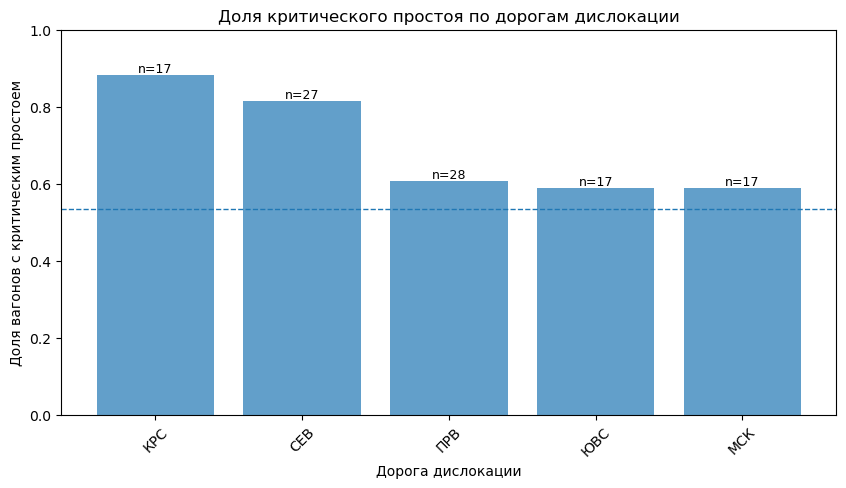

In [39]:
median_rate = risk_by_road['critical_idle_rate'].median()
top5 = risk_by_road.head(5)

plt.rcParams["figure.figsize"] = (10,5)

bars = plt.bar(
    top5['Дорога дислокации'],
    top5['critical_idle_rate'],
    alpha=0.7)

plt.ylabel('Доля вагонов с критическим простоем')
plt.xlabel('Дорога дислокации')
plt.title('Доля критического простоя по дорогам дислокации')
plt.xticks(rotation=45)
plt.ylim(0,1)
# Добавить линию  медианы на график
plt.axhline(
    y=median_rate,
    linestyle='--',
    linewidth=1,
    label='Медиана по всем дорогам'
)
# подписи n над столбцами
for bar, n in zip(bars, top5['count']):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f'n={n}',
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.show()

# На дорогах КРС и СЕВ доля вагонов с критическим простоем превышает 80%, что указывает на концентрацию операционных задержек 
#в данных сегментах инфраструктуры. При этом размер выборки по каждой дороге ограничен, что требует осторожной интерпретации результатов.

#### Проверка Гипотеза 2. Различия по дорогам дислокации
Доля вагонов  под погрузкой с критическим простоем и в ремонте около 80%, что указывает на концентрацию операционных задержек 
в данных сегментах инфраструктуры. При этом размер выборки по каждой дороге ограничен, что требует осторожной интерпретации результатов.
Статус «ремонт» отражает технический контур и частично пересекается с процессом простоя, поэтому результаты по данной категории интерпретируются ограниченно и используются преимущественно для описательного сравнения.

In [33]:

risk_by_status = (
    df.groupby('Состояние вагона')['critical_idle']
      .agg(['count','mean']).reset_index()
      .rename(columns={'mean':'critical_idle_rate'})
      .query('count >= 10')
      .sort_values('critical_idle_rate', ascending=False)
)

risk_by_status


,Состояние вагона,count,critical_idle_rate
3,Под погрузкой,99,0.808081
5,Ремонт,29,0.793103
2,Под выгрузкой,152,0.572368
4,Порожний ход,34,0.147059
0,Гружёный ход,109,0.128440


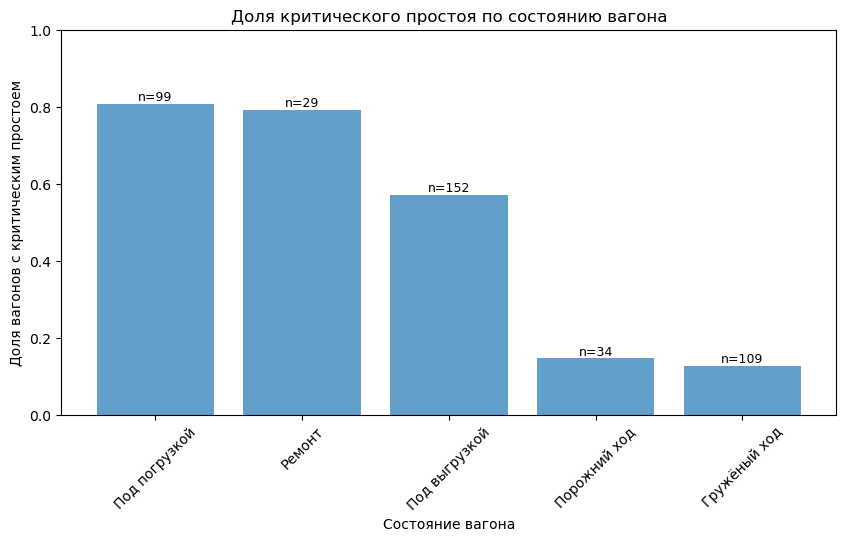

In [40]:

bars = plt.bar(
    risk_by_status['Состояние вагона'],
    risk_by_status['critical_idle_rate'],
    alpha=0.7)

plt.ylabel('Доля вагонов с критическим простоем')
plt.xlabel('Состояние вагона')
plt.title('Доля критического простоя по cостоянию вагона')
plt.xticks(rotation=45)
plt.ylim(0,1)
# подписи n над столбцами
for bar, n in zip(bars, risk_by_status['count']):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f'n={n}',
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.show()

#### Гипотеза 3. Текущая неисправность

Гипотеза не подтвердилась. В рамках данного датасета фактор текущей неисправности не демонстрирует связи с критическим простоем, что связано с крайне малым числом наблюдений.


In [38]:
risk_by_defect = (
    df.groupby('has_defect')['critical_idle']
      .agg(['count','mean']).reset_index()
      .rename(columns={'mean':'critical_idle_rate'})
)
risk_by_defect


,has_defect,count,critical_idle_rate
0,False,413,0.493947
1,True,12,0.500000


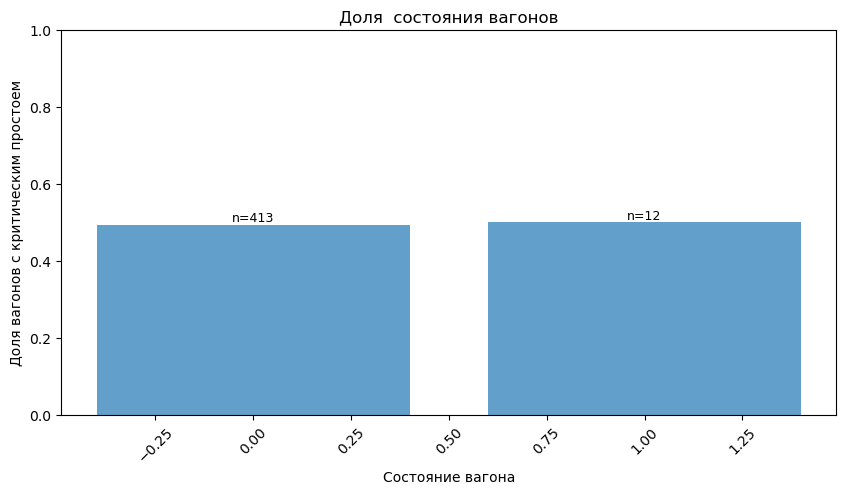

In [44]:
bars = plt.bar(
    risk_by_defect['has_defect'],
    risk_by_defect['critical_idle_rate'],
    alpha=0.7)

plt.ylabel('Доля вагонов с критическим простоем')
plt.xlabel('Состояние вагона')
plt.title('Доля  состояния вагонов')
plt.xticks(rotation=45)
plt.ylim(0,1)
# подписи n над столбцами
for bar, n in zip(bars, risk_by_defect['count']):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f'n={n}',
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.show()

### Результаты 
В рамках анализа операционного среза вагонного парка был изучен критический простой вагонов на станции дислокации (более 5 суток). Анализ показал, что критический простой распределён неравномерно и концентрируется в отдельных сегментах инфраструктуры и операционных состояний вагонов. Выявлены факторы, ассоциированные с повышенным риском простоя, а также факторы, не оказывающие значимого влияния в рамках имеющихся данных.

| Фактор                | Результат анализа                      | Статус         |
| --------------------- | -------------------------------------- | -------------- |
| Дорога дислокации     | Существенные различия, top-зоны риска  | Значим         |
| Состояние вагона      | Высокий риск под погрузкой и в ремонте | Значим         |
| Текущая неисправность | Различий не выявлено, малая выборка    | Неинформативен |

На отдельных дорогах дислокации доля вагонов с критическим простоем существенно превышает медианный уровень по выборке, что указывает на концентрацию операционных задержек в этих сегментах инфраструктуры.

Статус вагона оказывает заметное влияние на вероятность критического простоя: вагоны под погрузкой и находящиеся в ремонте демонстрируют наиболее высокий риск.

Наличие зафиксированной текущей неисправности не показало связи с критическим простоем в рамках данного датасета, что связано с крайне малой долей таких наблюдений.

Анализ позволяет выделить дороги и операционные состояния вагонов, требующие приоритетного управленческого контроля.
Результаты могут использоваться для фокусировки операционных проверок и детального анализа причин простоев в выявленных зонах риска.
